In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 72.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-linux_x86_64.whl size=61826008 sha256=30912a683da5f58e51ee159ac05c4d8316c7598b37165e77d39c9940506073bb
  Stored in directory: /root/.cache/pip/wheels/b8/36/bf/7ec7e363f796373cea3eb9ea94e83f5bbbb586d2edbf7e3417
Successfully built pystan
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=9435419 sha256=98e28b452f525e3a6b449285af272a8782b01f181334d70ac8f5a31235e34a02
  Stored in directory: /root/.cache/pip/wheels/da/a4/bb/dbed5db92b2183a753dd96cc8a56706a61484ff3959988

In [ ]:
from fbprophet import Prophet

In [124]:
df=pd.read_csv("/content/drive/MyDrive/CaseStudy-OW/02 Sales_Expense_InputFile.csv")
#loading the input data

In [125]:
#loading Output data
df_out=pd.read_excel("/content/drive/MyDrive/CaseStudy-OW/04 OutputFormat.xlsx")
dftype=pd.read_csv("/content/drive/MyDrive/CaseStudy-OW/03 Account_Potential_Data.csv")

#Data description


In [126]:
df.head(5)

,ACCOUNT_ID,Type,COUNTRY,PRODUCT,MONTH,UNIT_SALES (in Million $),Per Unit Expense,TOTAL_EXPENSE (in Million $),SALESFORCE_EXPENSE (in Million $),DIGITAL_EXPENSE (in Million $)
0,376321,Medium,COUNTRY 1,Drug_2,8/1/10,61.231684,5.827554,10.507271,6.100165,3.463933
1,376321,Medium,COUNTRY 1,Drug_2,9/1/10,47.286854,4.277412,11.055016,6.037500,3.830352
2,376321,Medium,COUNTRY 1,Drug_2,10/1/10,29.143185,1.919907,15.179476,8.310196,5.591070
3,376321,Medium,COUNTRY 1,Drug_2,11/1/10,74.909233,5.073759,14.764051,8.348021,5.254492
4,376321,Medium,COUNTRY 1,Drug_2,12/1/10,37.441141,2.455262,15.249345,9.054047,5.889636


In [127]:
#Creating month and year feature and a date type feature NDate
df = df.dropna()
df['NDate']= pd.to_datetime(df['MONTH'])
df=df.drop(['MONTH'], axis=1)
df['MONTH'] = df['NDate'].dt.month
df['YEAR'] = df['NDate'].dt.year

In [128]:
df.describe()

,ACCOUNT_ID,UNIT_SALES (in Million $),Per Unit Expense,TOTAL_EXPENSE (in Million $),SALESFORCE_EXPENSE (in Million $),DIGITAL_EXPENSE (in Million $),MONTH,YEAR
count,2.954100e+04,29541.000000,29541.000000,29541.000000,29541.000000,29541.000000,29541.000000,29541.000000
mean,1.920262e+06,77.467187,3.944587,23.217187,13.401026,8.867015,6.557801,2014.698013
std,5.091865e+06,225.941719,42.805988,65.255768,39.145709,26.094870,3.411392,2.303885
min,2.200000e+01,0.875579,-417.946027,-0.020494,-0.012094,-0.007104,1.000000,2010.000000
25%,2.326210e+05,13.309469,2.623738,4.572869,2.216660,1.412721,4.000000,2013.000000
50%,4.652960e+05,38.853087,3.232303,11.729950,6.497180,4.259820,7.000000,2015.000000
75%,6.868660e+05,78.964226,3.810495,23.681341,13.649810,9.033341,9.000000,2017.000000
max,2.380097e+07,10762.960580,6585.742495,1921.314960,1152.237836,767.869034,12.000000,2018.000000


#Treating Data
cleaning , Merging , renaming column


Input data


In [129]:
def z_scores(df_col):
    mean = df_col.mean()
    std = df_col.std()
    zscore = (df_col - mean) / std
    return zscore

# replace outliers with linearly interpolated values
outliers = df[z_scores(df['UNIT_SALES (in Million $)']) > 3]
df.loc[outliers.index, 'UNIT_SALES (in Million $)'] = df['UNIT_SALES (in Million $)'].interpolate()
outliers = df[z_scores(df['Per Unit Expense']) > 3]
df.loc[outliers.index, 'Per Unit Expense'] = df['Per Unit Expense'].interpolate()
outliers = df[z_scores(df['TOTAL_EXPENSE (in Million $)']) > 3]
df.loc[outliers.index, 'TOTAL_EXPENSE (in Million $)'] = df['TOTAL_EXPENSE (in Million $)'].interpolate()
outliers = df[z_scores(df['SALESFORCE_EXPENSE (in Million $)']) > 3]
df.loc[outliers.index, 'SALESFORCE_EXPENSE (in Million $)'] = df['SALESFORCE_EXPENSE (in Million $)'].interpolate()
outliers = df[z_scores(df['DIGITAL_EXPENSE (in Million $)']) > 3]
df.loc[outliers.index, 'DIGITAL_EXPENSE (in Million $)'] = df['DIGITAL_EXPENSE (in Million $)'].interpolate()

# replace negative values with linearly interpolated values
df.loc[df['UNIT_SALES (in Million $)'] < 0, 'UNIT_SALES (in Million $)'] = np.nan
df['UNIT_SALES (in Million $)'] = df['UNIT_SALES (in Million $)'].interpolate()
df.loc[df['Per Unit Expense'] < 0, 'Per Unit Expense'] = np.nan
df['Per Unit Expense'] = df['Per Unit Expense'].interpolate()
df.loc[df['SALESFORCE_EXPENSE (in Million $)'] < 0, 'SALESFORCE_EXPENSE (in Million $)'] = np.nan
df['SALESFORCE_EXPENSE (in Million $)'] = df['SALESFORCE_EXPENSE (in Million $)'].interpolate()
df.loc[df['TOTAL_EXPENSE (in Million $)'] < 0, 'TOTAL_EXPENSE (in Million $)'] = np.nan
df['TOTAL_EXPENSE (in Million $)'] = df['TOTAL_EXPENSE (in Million $)'].interpolate()
df.loc[df['DIGITAL_EXPENSE (in Million $)'] < 0, 'DIGITAL_EXPENSE (in Million $)'] = np.nan
df['DIGITAL_EXPENSE (in Million $)'] = df['DIGITAL_EXPENSE (in Million $)'].interpolate()


Output data

In [130]:
df_out = df_out.iloc[:, 1:] #Dropping First blank column
df_out.columns = df_out.iloc[0]#Making first row as header
df_out = df_out.drop(0) #dropping first row
#Creating New date column from existing month year info
df_out['NDate'] = pd.to_datetime(df_out['YEAR'].astype(str) + '-' + df_out['MONTH'].astype(str), format='%Y-%m')
#Merging Account potentiol to output data
df_output = df_out.merge(dftype, on=['ACCOUNT_ID'], how='left')
#renaming column to match input
df_output = df_output.rename(columns={'ACCOUNT_POTENTIAL': 'Type'})
df_output.head(3)

,ACCOUNT_ID,COUNTRY,PRODUCT,YEAR,MONTH,Sales Forecast (in Million $),Lower Prediction Interval (in Million $),Upper Prediction Interval (in Million $),NDate,Type
0,376321,COUNTRY 1,Drug_1,2018,11,NaN,NaN,NaN,2018-11-01,Medium
1,2097539,COUNTRY 1,Drug_1,2018,11,NaN,NaN,NaN,2018-11-01,Low
2,4613,COUNTRY 1,Drug_1,2018,11,NaN,NaN,NaN,2018-11-01,High


#EDA

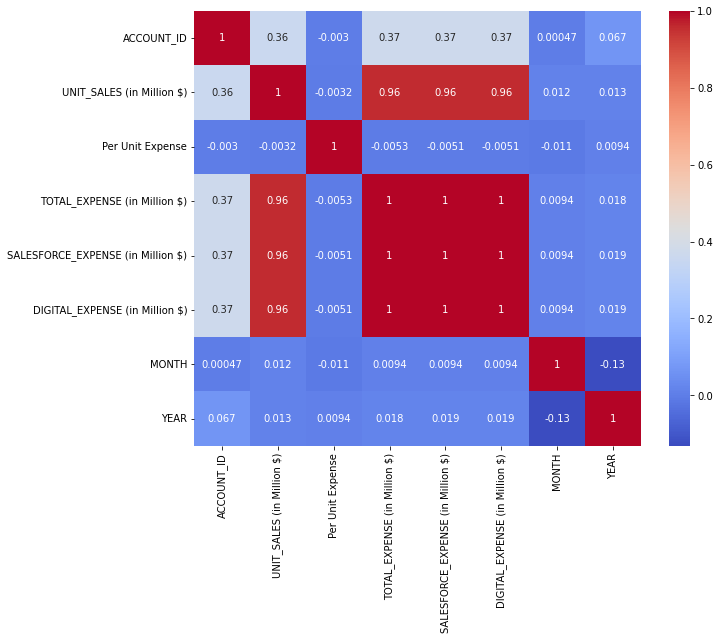

In [131]:
#Correlation Matrix
import seaborn as sns
import matplotlib.pyplot as plt
# calculate correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10,8))
# plot correlation matrix as heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


From Correlation Matrix we can say taking one expense from total, salesforce , digital will suffice


#Feature Engineering
functions

In [132]:
#Min date calculation
def min_date_cal(df):
  """ Function takes dataframe as input to calculate first sale date
  of drugs per account
  """
  #Starting date of drug for each account
  min_dates=df.groupby(['ACCOUNT_ID','PRODUCT'])['NDate'].min()
  min_dates_df = min_dates.reset_index()
  min_dates_df.columns = ['ACCOUNT_ID', 'PRODUCT', 'min_NDate']
  new_min = min_dates_df.pivot(index='ACCOUNT_ID', columns='PRODUCT', values='min_NDate').reset_index()
  new_min.columns.name = None
  new_min.columns = ['ACCOUNT_ID', 'Drug_1_min_NDate', 'Drug_2_min_NDate', 'Drug_3_min_NDate']
  return new_min #Returns a datframe with account id and their respective drugs first sale date
Mindates =min_date_cal(df)
Mindates.head()

,ACCOUNT_ID,Drug_1_min_NDate,Drug_2_min_NDate,Drug_3_min_NDate
0,22,2010-08-01,2010-08-01,2013-11-01
1,40,2010-08-01,2010-08-01,2013-12-01
2,3262,2010-08-01,2010-08-01,2013-12-01
3,3754,2010-08-01,2010-08-01,2014-02-01
4,4289,2010-08-01,2010-08-01,2014-01-01


In [133]:
#Age calculation : How old the drug is for each account on certain date , Ndate is required
def Account_Drug_Age(df,new_min):
  """ Function takes dataframe and first sale date dataframe as input to calculate
  age of drugs per account
  """
  df_merged = df.merge(new_min, on=['ACCOUNT_ID'], how='left')
  df_merged['D2_age'] = 0
  df_merged.loc[df_merged['NDate'] >= df_merged['Drug_2_min_NDate'], 'D2_age'] = (df_merged['NDate'] - df_merged['Drug_2_min_NDate']).dt.days
  df_merged['D1_age'] = 0
  df_merged.loc[df_merged['NDate'] >= df_merged['Drug_1_min_NDate'], 'D1_age'] = (df_merged['NDate'] - df_merged['Drug_1_min_NDate']).dt.days
  df_merged['D3_age'] = 0
  df_merged.loc[df_merged['NDate'] >= df_merged['Drug_3_min_NDate'], 'D3_age'] = (df_merged['NDate'] - df_merged['Drug_3_min_NDate']).dt.days
  mylist=[ 'Drug_1_min_NDate',	'Drug_2_min_NDate',	'Drug_3_min_NDate']
  df_merged=df_merged.drop(mylist, axis=1)
  #returning merged dataframe with ages as columns
  return df_merged

In [134]:
#One hot encoding function
def encode_cols(df,x):
    one_hot = pd.get_dummies(df,columns=x)
    #dropping inital categorical column
    return one_hot

Function to predict next 9 observation for any feature 
For eacha ccount and each drug type


In [135]:
def feature_ts(df,feat):
  """ Function takes dataframe and feature on which future  
  Prediction of the feature is done for drugs per account
  """
  # Group the data by account ID, date, and PRODUCT, and calculate the mean of the Salesforce expense
  grouped_data = df.groupby(['ACCOUNT_ID', 'NDate', 'PRODUCT'])[feat].agg(list).reset_index()
  # Convert Per Unit Expense column to float
  grouped_data[feat] = grouped_data[feat].apply(lambda x: x[0])
  # Create a dataframe to store the predicted values for each account, date, and PRODUCT
  predicted_values = pd.DataFrame(columns=['ACCOUNT_ID', 'NDate', 'PRODUCT', feat, 'Lower Bound', 'Upper Bound'])
  # Loop through each account and PRODUCT combination and make a prediction using Prophet
  for account_id in grouped_data['ACCOUNT_ID'].unique():
    for PRODUCT in grouped_data['PRODUCT'].unique():
        account_PRODUCT_data = grouped_data[(grouped_data['ACCOUNT_ID'] == account_id) & (grouped_data['PRODUCT'] == PRODUCT)]
        
        # Prepare the data for Prophet
        prophet_data = account_PRODUCT_data[['NDate', feat]]
        prophet_data.columns = ['ds', 'y']
        
        # Create the Prophet model and fit it to the data
        model = Prophet()
        model.fit(prophet_data)
        
        # Make a prediction for the next 9 observations
        future = model.make_future_dataframe(periods=9, freq='MS')
        forecast = model.predict(future)
        
        # Extract the predicted values and the upper and lower bounds
        predicted_values_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(9)
        predicted_values_df.columns = ['NDate', feat, 'Lower Bound', 'Upper Bound']
        predicted_values_df['ACCOUNT_ID'] = account_id
        predicted_values_df['PRODUCT'] = PRODUCT
        
        # Append the predicted values to the dataframe
        predicted_values = pd.concat([predicted_values, predicted_values_df], ignore_index=True)
  # Merge the predicted values with the original data
  #merged_data = pd.merge(grouped_data, predicted_values, on=['ACCOUNT_ID', 'NDate', 'PRODUCT'], how='left'
  # Reorder the columns
  #merged_data = merged_data[['ACCOUNT_ID', 'NDate', 'PRODUCT', feat, 'Lower Bound', 'Upper Bound']]
  # Print the predicted values for each account, date, and PRODUCT
  return predicted_values

#Applying Feature Engineering functions

1.Per unit expenses in Account Level for both Drug_1 and Drug_2 for output file

In [136]:
zx='Per Unit Expense'
Perunit_pred= feature_ts(df,zx)
Perunit_pred.columns

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Index(['ACCOUNT_ID', 'NDate', 'PRODUCT', 'Per Unit Expense', 'Lower Bound',
       'Upper Bound'],
      dtype='object')

In [137]:
Perunit_pred = Perunit_pred.rename(columns={'Lower Bound': 'PU_Lower_Bound', 'Upper Bound': 'PU_Upper_Bound'})
Perunit_pred.columns

Index(['ACCOUNT_ID', 'NDate', 'PRODUCT', 'Per Unit Expense', 'PU_Lower_Bound',
       'PU_Upper_Bound'],
      dtype='object')

In [138]:
#merging to output dataframe
df_output = pd.merge(df_output, Perunit_pred, on=['ACCOUNT_ID', 'NDate','PRODUCT'], how='left')
df_output.columns

Index(['ACCOUNT_ID', 'COUNTRY', 'PRODUCT', 'YEAR', 'MONTH',
       'Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)', 'NDate', 'Type',
       'Per Unit Expense', 'PU_Lower_Bound', 'PU_Upper_Bound'],
      dtype='object')

2. saleforce 

In [139]:
zx='SALESFORCE_EXPENSE (in Million $)'
Saleforce_pred= feature_ts(df,zx)
Saleforce_pred.columns

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Index(['ACCOUNT_ID', 'NDate', 'PRODUCT', 'SALESFORCE_EXPENSE (in Million $)',
       'Lower Bound', 'Upper Bound'],
      dtype='object')

In [140]:
Saleforce_pred = Saleforce_pred.rename(columns={'Lower Bound': 'SF_Lower_Bound', 'Upper Bound': 'SF_Upper_Bound'})
Saleforce_pred.columns

Index(['ACCOUNT_ID', 'NDate', 'PRODUCT', 'SALESFORCE_EXPENSE (in Million $)',
       'SF_Lower_Bound', 'SF_Upper_Bound'],
      dtype='object')

In [141]:
#Merging to ouput dataframe
df_output = pd.merge(df_output, Saleforce_pred, on=['ACCOUNT_ID', 'NDate','PRODUCT'], how='left')
df_output.columns

Index(['ACCOUNT_ID', 'COUNTRY', 'PRODUCT', 'YEAR', 'MONTH',
       'Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)', 'NDate', 'Type',
       'Per Unit Expense', 'PU_Lower_Bound', 'PU_Upper_Bound',
       'SALESFORCE_EXPENSE (in Million $)', 'SF_Lower_Bound',
       'SF_Upper_Bound'],
      dtype='object')

1. Applying one hot encoding

In [142]:
# dropping drug 3 as we dont need to predict as sales
df = df[df['PRODUCT'] != 'Drug_3']

In [143]:
# list of categorical values
# list of categorical
mylist = list(df.select_dtypes(include=['object']).columns)
mylist

['Type', 'COUNTRY', 'PRODUCT']

In [144]:
#one hot encoding for input
df=encode_cols(df,mylist)
df.columns

Index(['ACCOUNT_ID', 'UNIT_SALES (in Million $)', 'Per Unit Expense',
       'TOTAL_EXPENSE (in Million $)', 'SALESFORCE_EXPENSE (in Million $)',
       'DIGITAL_EXPENSE (in Million $)', 'NDate', 'MONTH', 'YEAR', 'Type_High',
       'Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2'],
      dtype='object')

In [145]:
#one hot encoding for output
df_output=encode_cols(df_output,mylist)
df_output.columns

Index(['ACCOUNT_ID', 'YEAR', 'MONTH', 'Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)', 'NDate',
       'Per Unit Expense', 'PU_Lower_Bound', 'PU_Upper_Bound',
       'SALESFORCE_EXPENSE (in Million $)', 'SF_Lower_Bound', 'SF_Upper_Bound',
       'Type_High', 'Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1',
       'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4',
       'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1', 'PRODUCT_Drug_2'],
      dtype='object')

2. Applying Drug Age

In [146]:
# Age calculation for input
df= Account_Drug_Age(df,Mindates)
df.columns

Index(['ACCOUNT_ID', 'UNIT_SALES (in Million $)', 'Per Unit Expense',
       'TOTAL_EXPENSE (in Million $)', 'SALESFORCE_EXPENSE (in Million $)',
       'DIGITAL_EXPENSE (in Million $)', 'NDate', 'MONTH', 'YEAR', 'Type_High',
       'Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age'],
      dtype='object')

In [147]:
# Age calculation for output
df_output= Account_Drug_Age(df_output,Mindates)
df_output.columns

Index(['ACCOUNT_ID', 'YEAR', 'MONTH', 'Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)', 'NDate',
       'Per Unit Expense', 'PU_Lower_Bound', 'PU_Upper_Bound',
       'SALESFORCE_EXPENSE (in Million $)', 'SF_Lower_Bound', 'SF_Upper_Bound',
       'Type_High', 'Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1',
       'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4',
       'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'D2_age',
       'D1_age', 'D3_age'],
      dtype='object')

In [148]:
len(df_output.columns)

26

In [149]:
#Rearranging colums sequence
new_cols = ['ACCOUNT_ID', 'NDate' ,'YEAR', 'MONTH', 
        'Type_High','Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age',
       'Per Unit Expense', 'PU_Lower_Bound', 'PU_Upper_Bound',
       'SALESFORCE_EXPENSE (in Million $)', 'SF_Lower_Bound', 'SF_Upper_Bound',
       'Sales Forecast (in Million $)','Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)']

df_output = df_output.reindex(columns=new_cols)
len(df_output.columns)

26

In [150]:
len(df.columns)
df.columns

Index(['ACCOUNT_ID', 'UNIT_SALES (in Million $)', 'Per Unit Expense',
       'TOTAL_EXPENSE (in Million $)', 'SALESFORCE_EXPENSE (in Million $)',
       'DIGITAL_EXPENSE (in Million $)', 'NDate', 'MONTH', 'YEAR', 'Type_High',
       'Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age'],
      dtype='object')

In [151]:
#Rearranging colums sequence
new_cols = ['ACCOUNT_ID', 'NDate' ,'YEAR', 'MONTH', 
        'Type_High','Type_Low', 'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age',
       'Per Unit Expense', 'SALESFORCE_EXPENSE (in Million $)','TOTAL_EXPENSE (in Million $)','DIGITAL_EXPENSE (in Million $)', 'UNIT_SALES (in Million $)']
df = df.reindex(columns=new_cols)
len(df.columns)

22

In [152]:
#Splitting the input into two parts where testing set for validation have 9 month observation
df_train = df.loc[df.NDate <= '2018-01-01'].copy() 
df_test = df.loc[df.NDate > '2018-01-01'].copy()

Dropping columns for both dataframes to train the model and have prediction

In [153]:
#input drops
df = df.drop(['ACCOUNT_ID', 'NDate','TOTAL_EXPENSE (in Million $)','DIGITAL_EXPENSE (in Million $)'], axis=1)
#output drops
df_output = df_output.drop(['ACCOUNT_ID', 'NDate'], axis=1)
print(df.columns)
print(df_output.columns)

Index(['YEAR', 'MONTH', 'Type_High', 'Type_Low', 'Type_Medium',
       'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3',
       'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1',
       'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age', 'Per Unit Expense',
       'SALESFORCE_EXPENSE (in Million $)', 'UNIT_SALES (in Million $)'],
      dtype='object')
Index(['YEAR', 'MONTH', 'Type_High', 'Type_Low', 'Type_Medium',
       'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3',
       'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1',
       'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age', 'Per Unit Expense',
       'PU_Lower_Bound', 'PU_Upper_Bound', 'SALESFORCE_EXPENSE (in Million $)',
       'SF_Lower_Bound', 'SF_Upper_Bound', 'Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)'],
      dtype='object')


In [157]:
df_train = df_train.drop(['ACCOUNT_ID', 'NDate','TOTAL_EXPENSE (in Million $)','DIGITAL_EXPENSE (in Million $)'], axis=1)
df_test = df_test.drop(['ACCOUNT_ID', 'NDate','TOTAL_EXPENSE (in Million $)','DIGITAL_EXPENSE (in Million $)'], axis=1)

KeyError: ignored

In [158]:
df_test = df_test.drop(['ACCOUNT_ID', 'NDate','TOTAL_EXPENSE (in Million $)','DIGITAL_EXPENSE (in Million $)'], axis=1)

# Modelling and validation

1.Salesforce prediction in Account Level for both Drug_1 and Drug_2

Merging them with Submission dataframe / replacing in testing data frame


In [159]:
#XGB Regression
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn.preprocessing

X_train=pd.DataFrame()
y_train =pd.DataFrame()
X_test=pd.DataFrame()
y_test=pd.DataFrame()

#Seperating Target variable and features
X_train=df_train.loc[:, df_train.columns != 'UNIT_SALES (in Million $)'] 
y_train['UNIT_SALES (in Million $)'] = df_train['UNIT_SALES (in Million $)']
X_test=df_test.loc[:, df_test.columns != 'UNIT_SALES (in Million $)']
y_test['UNIT_SALES (in Million $)']= df_test['UNIT_SALES (in Million $)'] 

#Creating XGBoost Model
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=5000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

output = reg.predict(X_test)
#storing the prediction values
df_test['Prediction'] =reg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[14:51:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [161]:
def mape(y_test, pred):
  """ A function to calculate MAPE accepts actual valyes and Predicted values"""
  y_test, pred = np.array(y_test), np.array(pred)
  mape = np.mean(np.abs((y_test - pred) / y_test))
  return mape

In [162]:
#Regression Model Performance 
print(mape(df_test['UNIT_SALES (in Million $)'], df_test['Prediction']))

0.05286936719456194


Feature importance 

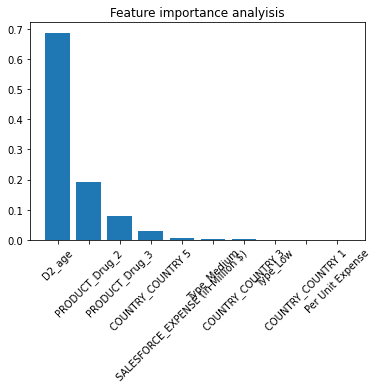

In [163]:
#Plotting Feature Importance
import matplotlib.pyplot as plt
features = ['Per Unit Expense',
       'SALESFORCE_EXPENSE (in Million $)',
       'Misc expenses', 'MONTH', 'YEAR', 'Type_High', 'Type_Low',
       'Type_Medium', 'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2',
       'COUNTRY_COUNTRY 3', 'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5',
       'PRODUCT_Drug_1', 'PRODUCT_Drug_2', 'PRODUCT_Drug_3', 'D2_age', 'D1_age', 'D3_age']
# Get feature importances from our random forest model
importances = reg.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

#Retraining
Training over whole input data set to predict submission df

In [166]:
X_all=pd.DataFrame()
y_all =pd.DataFrame()
X_all=df.loc[:, df.columns != 'UNIT_SALES (in Million $)'] 
y_all['UNIT_SALES (in Million $)'] = df['UNIT_SALES (in Million $)']

In [167]:
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=5000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        early_stopping_rounds=50,
       verbose=False)

[15:03:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

Predicting future sales


In [168]:
df_out=pd.read_excel("/content/drive/MyDrive/CaseStudy-OW/04 OutputFormat.xlsx")
df_out = df_out.iloc[:, 1:] #Dropping First blank column
df_out.columns = df_out.iloc[0]#Making first row as header
df_out = df_out.drop(0)

In [170]:
len(df_out)

2250

In [177]:
df_output=df_output.drop(['Sales Forecast (in Million $)',
       'Lower Prediction Interval (in Million $)',
       'Upper Prediction Interval  (in Million $)'], axis=1)

In [181]:
df_out['Sales Forecast (in Million $)'] =0
df_out['Lower Prediction Interval (in Million $)'] =0
df_out['Upper Prediction Interval  (in Million $)'] =0
df_out[["YEAR", "MONTH"]] = df_out[["YEAR", "MONTH"]].apply(pd.to_numeric)


In [191]:
print(X_main.dtypes)

YEAR                                  object
MONTH                                 object
Type_High                              uint8
Type_Low                               uint8
Type_Medium                            uint8
COUNTRY_COUNTRY 1                      uint8
COUNTRY_COUNTRY 2                      uint8
COUNTRY_COUNTRY 3                      uint8
COUNTRY_COUNTRY 4                      uint8
COUNTRY_COUNTRY 5                      uint8
PRODUCT_Drug_1                         uint8
PRODUCT_Drug_2                         uint8
D2_age                                 int64
D1_age                                 int64
D3_age                                 int64
Per Unit Expense                     float64
SALESFORCE_EXPENSE (in Million $)    float64
dtype: object


In [192]:
df_output['YEAR'] = df_output['YEAR'].astype('int64')
df_output['MONTH'] = df_output['MONTH'].astype('int64')


In [195]:
df_output.columns

Index(['YEAR', 'MONTH', 'Type_High', 'Type_Low', 'Type_Medium',
       'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3',
       'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1',
       'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age', 'Per Unit Expense',
       'PU_Lower_Bound', 'PU_Upper_Bound', 'SALESFORCE_EXPENSE (in Million $)',
       'SF_Lower_Bound', 'SF_Upper_Bound', 'Sales Forecast (in Million $)'],
      dtype='object')

In [201]:

df_output=df_output.drop(['Sales Forecast (in Million $)'], axis=1)
df_output.columns

Index(['YEAR', 'MONTH', 'Type_High', 'Type_Low', 'Type_Medium',
       'COUNTRY_COUNTRY 1', 'COUNTRY_COUNTRY 2', 'COUNTRY_COUNTRY 3',
       'COUNTRY_COUNTRY 4', 'COUNTRY_COUNTRY 5', 'PRODUCT_Drug_1',
       'PRODUCT_Drug_2', 'D2_age', 'D1_age', 'D3_age', 'Per Unit Expense',
       'PU_Lower_Bound', 'PU_Upper_Bound', 'SALESFORCE_EXPENSE (in Million $)',
       'SF_Lower_Bound', 'SF_Upper_Bound'],
      dtype='object')

In [202]:
X_main=pd.DataFrame()
X_main= df_output.drop(['PU_Lower_Bound', 'PU_Upper_Bound','SF_Lower_Bound', 'SF_Upper_Bound'], axis=1)
X_low=pd.DataFrame()
X_low= df_output.drop(['Per Unit Expense', 'PU_Upper_Bound','SALESFORCE_EXPENSE (in Million $)', 'SF_Upper_Bound'], axis=1)
X_up=pd.DataFrame()
X_up= df_output.drop(['Per Unit Expense', 'PU_Lower_Bound','SALESFORCE_EXPENSE (in Million $)', 'SF_Lower_Bound'], axis=1)

df_out['Sales Forecast (in Million $)'] =reg.predict(X_main)
X_low = X_low.rename(columns={'PU_Lower_Bound': 'Per Unit Expense', 'SF_Lower_Bound': 'SALESFORCE_EXPENSE (in Million $)'})
df_out['Lower Prediction Interval (in Million $)'] =reg.predict(X_low)
X_up = X_up.rename(columns={'PU_Upper_Bound': 'Per Unit Expense', 'SF_Upper_Bound': 'SALESFORCE_EXPENSE (in Million $)'})
df_out['Upper Prediction Interval  (in Million $)'] =reg.predict(X_up)


Output printing and generating output file

In [203]:
#printing and saving the output as Excel File
print(df_out)
df_out.to_excel('Output.xlsx', index=False)

0    ACCOUNT_ID    COUNTRY PRODUCT  YEAR  MONTH  \
1        376321  COUNTRY 1  Drug_1  2018     11   
2       2097539  COUNTRY 1  Drug_1  2018     11   
3          4613  COUNTRY 1  Drug_1  2018     11   
4        541958  COUNTRY 1  Drug_1  2018     11   
5        609418  COUNTRY 1  Drug_1  2018     11   
...         ...        ...     ...   ...    ...   
2246     558644  COUNTRY 5  Drug_2  2019      7   
2247     582457  COUNTRY 5  Drug_2  2019      7   
2248     343610  COUNTRY 5  Drug_2  2019      7   
2249     424763  COUNTRY 5  Drug_2  2019      7   
2250       6203  COUNTRY 5  Drug_2  2019      7   

0     Sales Forecast (in Million $)  Lower Prediction Interval (in Million $)  \
1                         13.668577                                  6.264614   
2                         50.726311                                 25.369518   
3                         77.007805                                 42.834625   
4                         28.386126                            